# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Com o isolamento social em função da pandemia houve um aumento das transações online. Segundo o SPC, cerca de 9 milhões de pessoas já foram vítimas de algum tipo de fraude financeira nos últimos 12 meses, sendo metade dessas fraudes aconteceram em transações pela internet. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo nos últimos 12 meses.

<p align=center><img src="https://raw.githubusercontent.com/inaepmachado/Portfolio/master/imagens/cc.jpeg" width="30%"></p>

Quando o próprio banco ou fintech percebe que a compra é atípica para aquele cliente, ocorre o bloqueio do cartão e a transação não se concretiza. Porém, quando não há essa identificação por parte das instituições e a compra é autorizada, o lojista acaba ficando com o prejuízo, uma vez que ele enviou o produto e não receberá o pagamento por ele. 

Por outro lado, um fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento. Apesar de haver toda uma justificativa por parte dos bancos, o desgaste com o cliente pode ser imensurável, chegando a perder esse cliente para a concorrência.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. Dispondo de grandes volumes de dados histórico, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas, mas sempre com a preocupação de não machucar a relação entre a instituição e o cliente.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente *desbalanceado*, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as features são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por V1, V2, V3 ... V28.

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA). A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**. Esses componentes são em número menor ou igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas V1, V2, V3 ... V28.

In [1]:
# suprimir os warnings - podemos escrever de duas maneiras, conforme abaixo
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [2]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import classification_report
from sklearn.metrics          import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling  import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`, puxando direto do google drive, conforme abaixo.

In [3]:
# importar os dados para um dataframe
file_path = "https://www.dropbox.com/s/mh55h3s3enf2esv/creditcard.csv?dl=1"

df = pd.read_csv(file_path)

Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## Análise Exploratória

In [4]:
# ver as primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

* As 5 primeiras entradas permitem entender como a transformação PCA deixou as *features* descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste *link*](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

* As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.

* A variável alvo está representada na coluna `Class`, onde:
    * **0:** transação normal; e
    * **1:** transação fraudulenta.

In [5]:
# ver o resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Verificando abaixo o resumo estatístico, por meio do método `describe()`, podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna `Time`.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado. Abaixo veremos a dispersão desses valores no boxplot, pois aparentemente há outliers nesta variável, o quartil 3 apresenta um valor muito inferior ao valor máximo da variável.

In [6]:
# ver se há valores ausentes
df.isnull().sum().max()

0

Quanto à qualidade do *dataset*, este não apresentou nenhum valor ausente ou que demandasse uma etapa de limpeza. Na função acima, perceba que o maior valor por coluna para valores nulos é zero, o que confirma que não há valores ausentes.

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

Classe Zero (não fraude) do dataset:284315

Classe Um (fraude) do dataset:492

As fraudes representam 0.1727% do dataset.



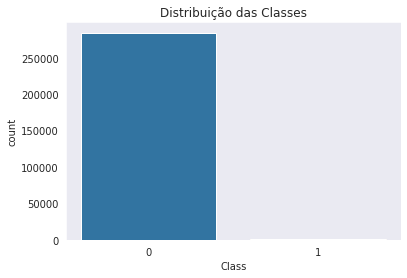

In [7]:
# ver o balanceamento das Classes

print("Classe Zero (não fraude) do dataset:{:.0f}\n".format((df[df.Class == 0].shape[0])));
print("Classe Um (fraude) do dataset:{:.0f}\n".format((df[df.Class == 1].shape[0])));

print("As fraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0])*100));

# plotar gráfico de barras para as Classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot();

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

Plotou-se também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo (`Time`).

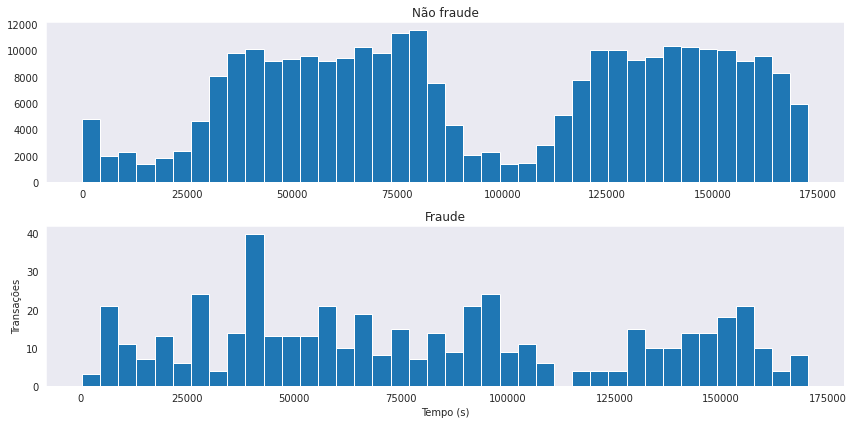

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Não fraude')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraude')

plt.xlabel('Tempo (s)')
plt.ylabel('Transações')
plt.tight_layout()

No entanto, não foi identificada nenhum informação a partir das distribuições de frequência abaixo.

Seguindo a análise exploratória, plotou-se os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`. Como falamos acima, a diferença entre o valor do terceiro quartil e do valor máximo está alta, mostrando que pode haver outliers na variável. Abaixo iremos fazer uma visão aberta por classe, tentando entender como é a composição entre elas dessa variável.

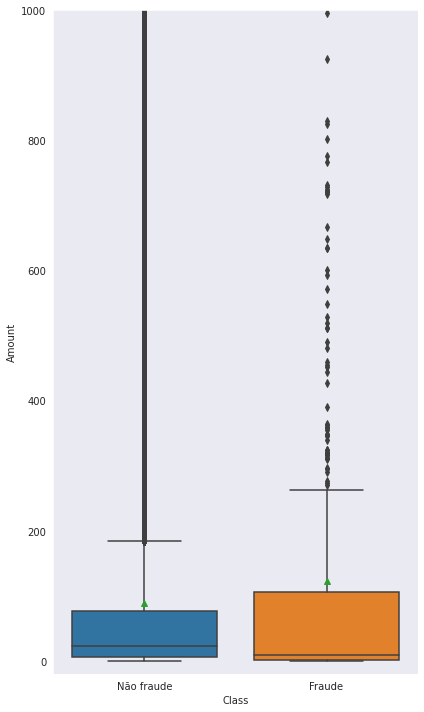

In [9]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 1000))
plt.xticks([0, 1], ['Não fraude', 'Fraude'])

plt.tight_layout()

De uma maneira geral, percebe-se uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de *machine learning*.

In [10]:
df[(df.Class == 1)]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

As informações estatísticas para `df.Class == 1` mostram que a sua média exata está em 122,21 e a mediana em 9,25. Novamente olhando os outliers, identificamos uma discrepância entre o Q3 e o máximo.

Vamos olhar o comportamento da classe de `Não fraude`.

In [11]:
df[(df.Class == 0)]['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

As informações estatísticas para `df.Class == 0` mostram que a sua média exata está em 88,29 e a mediana em 22. Novamente olhando os outliers, identificamos uma discrepância entre o Q3 e o máximo maior ainda.

Todo esse desbalanceamento, seja entre a quantidade de `zeros` e `uns` da Classe, seja na existência de outliers pode comprometer o treinamento do modelo, principalmente com relação à estabilidade.

O gráfico de densidade é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias. Ou seja, será que existe uma correlação entre as variáveis explicativas e a variável resposta `Classe`?

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente.

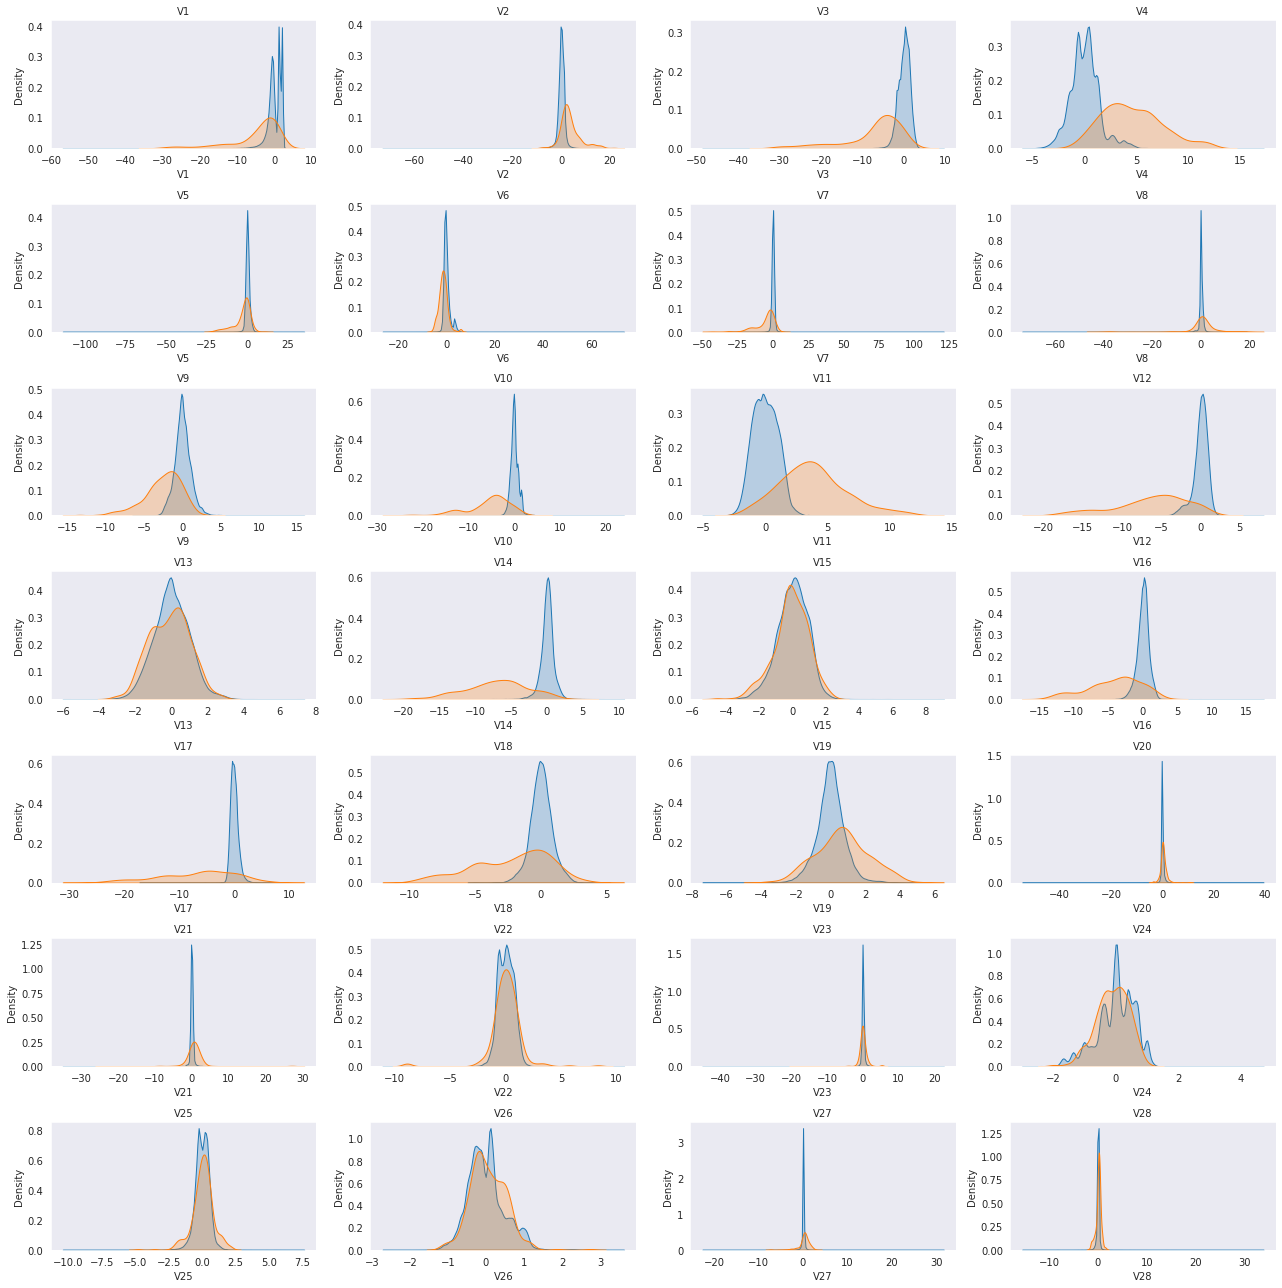

In [12]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

Veja como exemplo as variáveis `V3`, `V4`, `V10` e `V11`, como elas são bem distintas.
Por outro lado, variáveis como `V8`, `V13` e `V15` são muito similares, apresentando aproximadamente o mesmo comportamento entre as duas classes.

Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas, pois apresentam valores outliers que podem e devem ser tratados.

## Preparando os dados

Para que os dados possam alimentar o modelo de Regressão Logística que iremos construir, nesta etapa de preparação iremos:

* Padronizar as *features* `Time` e `Amount`, que estão em outra ordem de grandeza;
* Dividir entre dados de treino e teste;
* Balancear os dados a fim de evitar uma baixa performance para a classe 1 e *overfitting*.

*1) Padronizar `Time` e `Amount`*

Para esta etapa, uma vez que a coluna `Amount` possui *outliers*, será usada a padronização por meio da classe `StandardScaler`.

In [13]:
# padronizar as colunas Time e Amount
df_clean = df.copy() # fazendo uma cópia do original para efetuar a padronização

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

#df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,std_amount,std_time
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964,-1.996583
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475,-1.996583
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686,-1.996562
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534,-1.996562
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403,-1.996541


*2) Dividir entre conjuntos de treino e teste*

Antes de proceder com o balanceamento de dados, devemos splitar os dados já existentes entre treino e teste. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.

Para garantir que os conjuntos de treino e teste tenham a mesma quantidade de classes proporcionalmente, passamos `stratify=True`. Isso fará com que a divisão reflita exatamente o conjunto completo na distribuição dos dados em ambos os conjuntos, sem que haja algum viesamento na divisão, deixando determinadas classes somente no `treino`e outras somente no `teste`.

In [14]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, shuffle=True)

In [15]:
# verificando como ficou a divisão dos dados entre treino (75%) e teste (25%)
print("Treino:{:.0f}".format((X_train.shape[0])));
print("Teste:{:.0f}".format((X_test.shape[0])));

print("\nA base de treino confirma ter a divisão de {:.0f}% do dataset.\n".format((X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))*100));

Treino:213605
Teste:71202

A base de treino confirma ter a divisão de 75% do dataset.



*3) Balanceamento dos dados*

Como foi verificado acima, temos uma base de estudo com forte desbalanceamento, tendo 0,17% de fraude somente. Se fizermos o modelo da base como está, sem rebalancear, teremos uma grande chance do modelo começar a dar muitos falsos negativos, ou seja, identificar como não sendo fraude, quando na verdade é fraude.
Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar *Under-sampling*, preservando a classe minoritária fraude 
(0,17% é fraude).

In [16]:
# verificando o volume de fraude 
df_clean_class_1 = df_clean[df_clean.Class == 1].shape[0]

print(df_clean_class_1)
# volume de fraude na amostra limpa de já splitando treino-teste
print(df_clean_class_1*0.75)

492
369.0


Fiz a verificação acima somente para termos conhecimento do volume que iremos trabalhar na base de treino dos casos de fraude, já limpos e padronizados. Isso serve para na próxima etapa validarmos com o volume final que será trabalhado.

1    369
0    369
dtype: int64


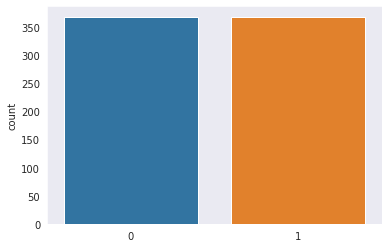

In [17]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);


É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste *notebook*).

Também chegamos ao volume esperado da classe de fraude, mostrando que o balanceamento foi feito corretamente. Esta verificação não é obrigatória, mas importante para sempre termos controle dos dados que estamos trabalhando.

Com os dados balanceados, podemos ver a matriz de correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras.

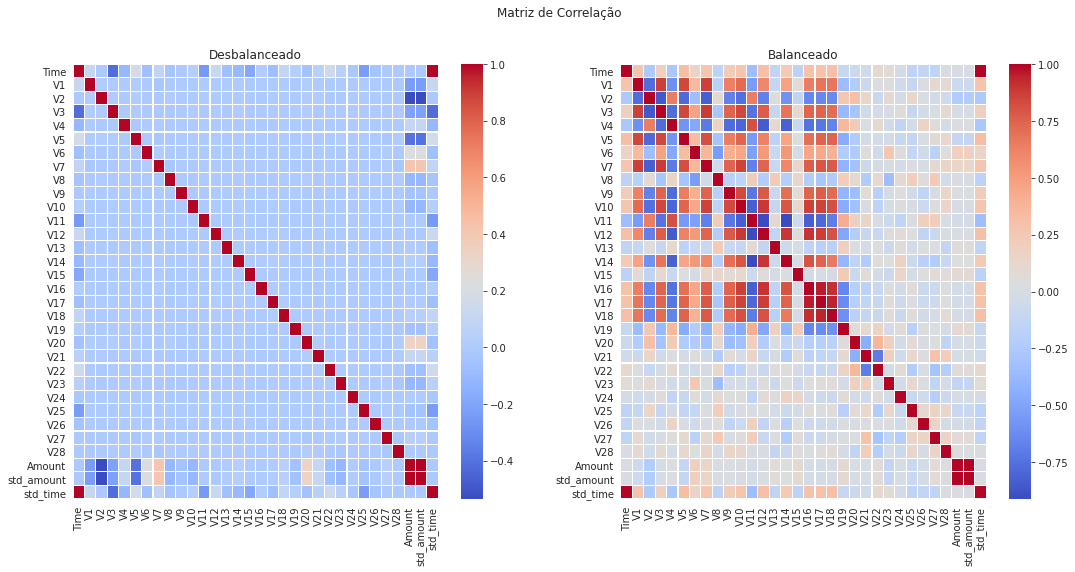

In [18]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()

# cria o espaço para aparecer o gráfico da correlação
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

# cria gráfico de correlação da variável desbalanceada
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

# cria gráfico de correlação da variável balanceada
sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

Observe como sem o balanceamento de dados, a matriz de correlação não trazia nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento. O que isso significa? Que muitas variáveis possuem correlação alta entre elas para detecção de fraude, porém com os dados desbalanceados, por haver somente 0,17% de fraude, temos uma visão totalmente distorcida de como essas variáveis se relacionam.

## Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`, onde estão devidamente balanceados. Na sequência, serão realizadas as previsões sobre os dados de teste.

In [19]:
# instanciar e treinar um modelo de Regressão Logística

# rodar com a semente aleatória: utilizamos a semente toda vez que treinamos o modelo para chegarmos ao mesmo resultado de treino,
# uma vez que estamos utilizando uma amostra aleatória e não o banco de dados completo.

# rodar o modelo nas variáveis já balanceadas X_rus, y_rus
np.random.seed(2) # podemos escolher qualquer valor, somente precisamos manter o mesmo
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada. Como apresentado [neste artigo](http://sigmoidal.ai/como-lidar-com-dados-desbalanceados/), você pode ter uma acurácia de 99,88% e detectar menos de 60% das fraudes.

Observe a matriz de confusão para ver a taxa de acertos para transações fraudulentas, ou pela coluna *recall* do Relatório de Classificação. 

Uma outra métrica considerada interessante para se avaliar a eficácia é a [AUC ROC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se 95% de AUC.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9613    0.9802     71079
           1     0.0381    0.8862    0.0731       123

    accuracy                         0.9612     71202
   macro avg     0.5189    0.9237    0.5266     71202
weighted avg     0.9981    0.9612    0.9786     71202

Acurácia: 0.9612

AUC: 0.9237



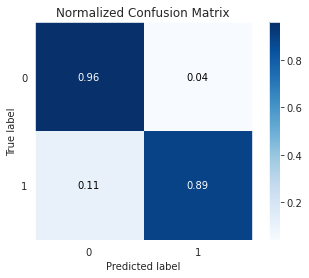

In [20]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

## Conclusões

Como você pode observar, não se trata de um problema trivial. Apesar dos dados estarem bem tratados e limpos, sem valores ausentes ou variáveis categóricas, o desbalanceamento e a Transformação PCA demandaram um trabalho considerável.

A decisão de se utilizar como metodologia o primeiro projeto com construção de modelo uma Regressão Logística, obviamente que há espaço para testar o desempenho com outros algoritmos de classificação, além de otimizar seus parâmetros, apesar do bom resultado final.

## Recomendações
Como recomendações de estudo, onde muito se foi baseado para criação desse modelo, irei passar alguns links bem interessantes.

O `Scikit-learn` [documentação oficial](https://scikit-learn.org/stable/getting_started.html), é uma biblioteca *open source* que suporta aprendizado supervisionado e não supervisionado, além de prover várias ferramentas para *model fitting*, pré-processamento de dados, seleção de modelos e avaliação, entre outras várias utilidades.

Leitura do paper para aprofundar no entendimento da arquitetura da biblioteca [API design for machine learning software: experiences from the scikit-learn project](https://arxiv.org/abs/1309.0238).

Como no modelo apresentado, precisamos rebalancear o banco de dados para termos um melhor desempenho do modelo. Nester artigo, você irá entender como lidar com esse tipo de situação: [Como lidar com dados desbalanceados](https://sigmoidal.ai/como-lidar-com-dados-desbalanceados/)

Para métricas de avaliação de modelo temos vários critérios para utilizar, cada um de acordo com a disposição dos dados, do modelo criado e com o tipo de avaliação que se queira fazer. Abaixo temos algumas indicações que ajudam a esclarecer bem as dúvidas e a direcionar qual escolha podemos fazer:

- Para modelos de regressão: artigos
[1](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d), [2](https://www.dataquest.io/blog/understanding-regression-error-metrics/) e [3](https://towardsdatascience.com/art-of-choosing-metrics-in-supervised-models-part-1-f960ae46902e)

- Para modelos de classificao: artigos [1](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/), [2](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) e [3](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772)


## Dúvidas, reclamações, sugestões etc

Estou iniciando esse projeto onde todo estudo que fizer irei compartilhar por aqui e gostaria muito de sugestões, reclamações, dúvidas etc.

Por favor, entre em contato direto comigo, abaixo deixo meus contatos para toda troca de toda informação.

- [Linkedin](www.linkedin.com/in/inaepmachado)

- [Email](inae.pmachado@gmail.com)

- [Github](https://github.com/inaepmachado)

Vlw!
